In [1]:
import numpy as np

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

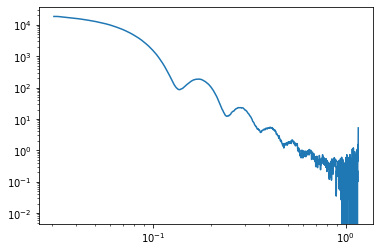

In [2]:
# Read measured data 
data = np.loadtxt('data_examples/Au_cubes_50nm.dat')
fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

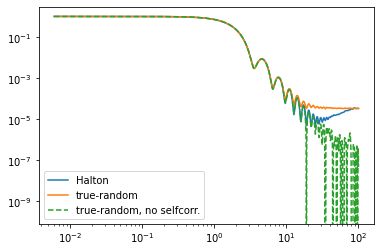

In [3]:
# Compute single-particle scattering curve
# number of scatterers
N = 30000

# generates 3D triangular mesh out of stl-files
# ideal cube
test_mesh = CDEF.read_stl('stl_files_examples/cube.stl')

# cloud of punctiform scatterers based on mesh 
# from Halton series. Possible other values: sobol, random
#
test_cloud = CDEF.stl_cloud(test_mesh, N, sequence='halton')
test_cloud_random = CDEF.stl_cloud(test_mesh, N, sequence='random')

# single-particle scattering curve
# rbins - number of bins
# 
test_curve = CDEF.scattering_mono(test_cloud, selfcorrelation=True)
test_curve_random = CDEF.scattering_mono(test_cloud_random, selfcorrelation=True)
#
#no selfcorrelation
test_curve_random_no_selfcorr = CDEF.scattering_mono(test_cloud_random, selfcorrelation=False)


fig, ax = plt.subplots()
ax.loglog(test_curve[:,0], test_curve[:,1], label = "Halton")
ax.loglog(test_curve_random[:,0], test_curve_random[:,1], label = "true-random")
ax.loglog(test_curve_random_no_selfcorr[:,0], test_curve_random_no_selfcorr[:,1], '--', label = "true-random, no selfcorr.")
ax.legend()

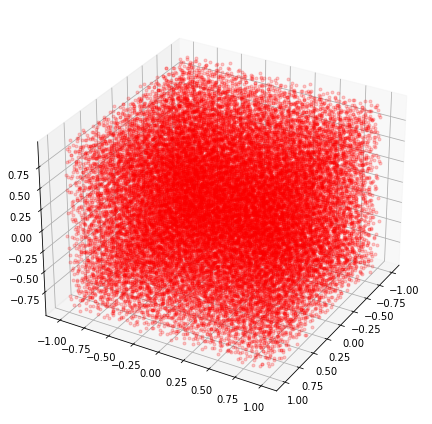

In [4]:
#Visualization of point cloud
fig = plt.figure(figsize=(8,6)) 

ax = fig.add_subplot(111, projection='3d')

ax.plot(test_cloud.T[0], test_cloud.T[1], test_cloud.T[2], "r.", alpha=0.2) 

ax.view_init(30, 30)

plt.tight_layout()
plt.show()

Prior to fitting the experimental data $I_{\mathrm{EXP}}$, we want to plot the initial fit parameters $(q, \, N_{C}, \, \mathrm{mean}, \, \sigma, \, c_0)$ of our model/fit function $I_{\mathrm{MOD}}$ to check if our guess is close enought to a possible minimum of the parameter space of 

\begin{eqnarray}
\chi ^2 = \frac{1}{N_{q} - M} \sum_{i}^{N_{q}} \Big( \frac{I_{\mathrm{EXP}}(q_{i}) - I_{\mathrm{MOD}} (q_{i})}{\sigma (I_{\mathrm{EXP}} (q_{i}))} \Big)^2
\end{eqnarray}

with 


\begin{eqnarray}
I_{\mathrm{MOD}} (q, \, N_{C}, \, \mathrm{mean}, \, \sigma, \, c_0) =  N_{\mathrm{C}} \, \int_{0}^{\infty} d(R \mathrm{;} \, \mathrm{mean}, \, \sigma) \, \vert F(q,R) \vert^2 \, dR + c_0,
\end{eqnarray}

and $d(R \mathrm{;} \, \mathrm{mean}, \, \sigma)$ being the size distribution chosen.

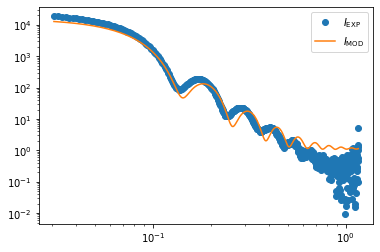

In [5]:
#Initial guess of fit parameters must be fit
N_C, mean, sigma, c0 =  1e-06, 25, 0.2, 1
inital_guess = N_C, mean, sigma, c0
########################################

initial_fit = CDEF.scattering_model(test_curve, data[:,0],*inital_guess)
fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1], 'o', label = "$I_{\mathrm{EXP}}$")
ax.loglog(initial_fit[:,0], initial_fit[:,1],'-', label = "$I_{\mathrm{MOD}}$")
ax.legend()

In [6]:
#Lognormal distribution
Gaussian=False


#Fit
tic = time.time()
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, test_curve, Gaussian), 
                                     method = 'Powell', options={'disp' : True})
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))

Optimization terminated successfully.
         Current function value: 34.081348
         Iterations: 7
         Function evaluations: 494
Calculation time = 114.25485849380493 s


The fit results of the $\mathrm{mean}$ as well as $\sigma$ refer to half of the length of the largest bounding box edge which is normalized to unity, i.e. for a cube, the values of these fit variables must be multiplied by $2$ to get the face-to-face distance and the according standard deviation.

In [7]:
#Results of parameters
fit_result.x

array([ 1.14521631e-06,  2.60334600e+01,  1.37394403e+00, -2.29281889e-01])

In [8]:
#q-range of fit
qvec = np.logspace(-3,0,1000)

fit = CDEF.scattering_model(test_curve, qvec, *fit_result.x)

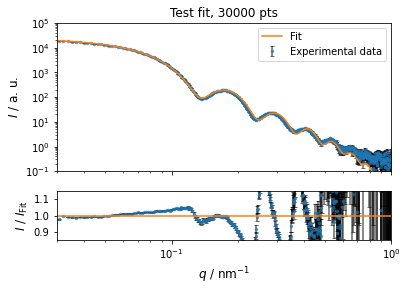

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

ax[0].set_title('Test fit, {} pts'.format(N))
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
ax[0].set_yscale('log')

#Frame limits
ax[0].set_ylim([1e-1, 1e5])
ax[0].set_xlim([3e-2, 1e0])

ax[0].errorbar(data[:,0], data[:,1], 
               yerr = data[:,2], fmt='.', ecolor='k', 
               capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

ax[0].legend()

#########################################
ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

#Frame limits
ax[1].set_ylim([0.85, 1.15])

ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
              yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
               fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
               label = 'Experimental data', zorder=1)

ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

plt.show()

The experimental data $I_{\mathrm{EXP}}$ can also be fitted using a cubic model with $\textbf{rounded}$ edges.

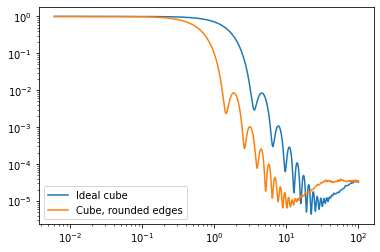

In [10]:
# generates 3D triangular mesh out of stl-files
# cube with rounded edges
test_mesh_round = CDEF.read_stl('stl_files_examples/cube_round_edges.stl')

# cloud of punctiform scatterers based on mesh 
#
test_cloud_round = CDEF.stl_cloud(test_mesh_round, N, sequence='halton')

# single-particle scattering curve
# 
test_curve_round = CDEF.scattering_mono(test_cloud_round, selfcorrelation=True)
#

fig, ax = plt.subplots()
ax.loglog(test_curve[:,0], test_curve[:,1], label = "Ideal cube")
ax.loglog(test_curve_round[:,0], test_curve_round[:,1], label = "Cube, rounded edges")
ax.legend()

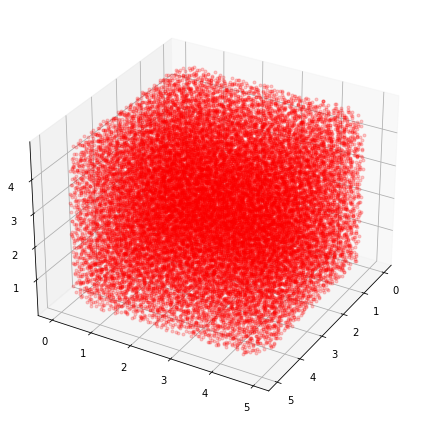

In [11]:
#Visualization of point cloud with rounded edges
fig = plt.figure(figsize=(8,6)) 

ax = fig.add_subplot(111, projection='3d')

ax.plot(test_cloud_round.T[0], test_cloud_round.T[1], test_cloud_round.T[2], "r.", alpha=0.2) 

ax.view_init(30, 30)

plt.tight_layout()
plt.show()

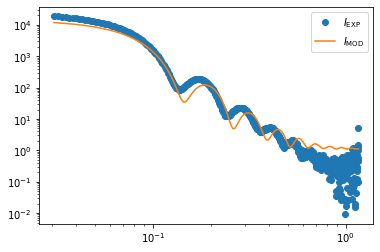

In [12]:
#Initial guess of fit parameters
N_C, mean, sigma, c0 =  1e-06, 25, 0.2, 1
inital_guess = N_C, mean, sigma, c0
########################################

initial_fit = CDEF.scattering_model(test_curve_round, data[:,0],*inital_guess)
fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1], 'o', label = "$I_{\mathrm{EXP}}$")
ax.loglog(initial_fit[:,0], initial_fit[:,1],'-', label = "$I_{\mathrm{MOD}}$")
ax.legend()

In [13]:
#Lognormal distribution
Gaussian=False


#Fit
tic = time.time()
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, test_curve_round, Gaussian), 
                                     method = 'Powell', options={'disp' : True})
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))

Optimization terminated successfully.
         Current function value: 22.729761
         Iterations: 6
         Function evaluations: 419
Calculation time = 95.08724904060364 s


In [14]:
#Results of parameters
fit_result.x

array([ 1.13995936e-06,  2.63623761e+01,  1.59681536e+00, -8.72449377e-02])

In [15]:
#q-range of fit
qvec = np.logspace(-3,0,1000)

fit = CDEF.scattering_model(test_curve_round, qvec, *fit_result.x)

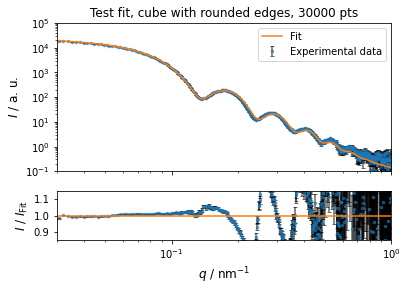

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

ax[0].set_title('Test fit, cube with rounded edges, {} pts'.format(N))
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
ax[0].set_yscale('log')

#Frame limits
ax[0].set_ylim([1e-1, 1e5])
ax[0].set_xlim([3e-2, 1e0])

ax[0].errorbar(data[:,0], data[:,1], 
               yerr = data[:,2], fmt='.', ecolor='k', 
               capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

ax[0].legend()

#########################################
ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

#Frame limits
ax[1].set_ylim([0.85, 1.15])

ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
              yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
               fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
               label = 'Experimental data', zorder=1)

ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

plt.show()